# 5. Calibration of single-ended measurement with OLS

Use WLS instead. See `examples/notebooks/07Calibrate_single_wls.ipynb`.

A double ended calibration is performed with Ordinary Least Squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are considered equal here and no variance or confidence interval is calculated.

Note that the internal reference section can not be used since there is a connector between the internal and external fiber and therefore the integrated differential attenuation cannot be considered to be linear anymore.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

%matplotlib inline

/Users/bfdestombe/anaconda3/envs/dts/lib/python3.7/typing.py:847: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'single_ended')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds100 = ds.sel(x=slice(-30, 101))  # only calibrate parts of the fiber, in meters
sections = {
            'probe1Temperature':    [slice(20, 25.5)],  # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
            }
ds100.sections = sections

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended
Reading the data from disk


In [3]:
print(ds100.calibration_single_ended.__doc__)


        Calibrate the Stokes (`ds.st`) and anti-Stokes (`ds.ast`) data to
        temperature using fiber sections with a known temperature
        (`ds.sections`) for single-ended setups. The calibrated temperature is
        stored under `ds.tmpf` and its variance under `ds.tmpf_var`.

        In single-ended setups, Stokes and anti-Stokes intensity is measured
        from a single end of the fiber. The differential attenuation is assumed
        constant along the fiber so that the integrated differential attenuation
        may be written as (Hausner et al, 2011):

        .. math::

            \int_0^x{\Delta\alpha(x')\,\mathrm{d}x'} \approx \Delta\alpha x

        The temperature can now be written from Equation 10 [1]_ as:

        .. math::

            T(x,t)  \approx \frac{\gamma}{I(x,t) + C(t) + \Delta\alpha x}

        where

        .. math::

            I(x,t) = \ln{\left(\frac{P_+(x,t)}{P_-(x,t)}\right)}


        .. math::

            C(t) = \ln{\left(\frac{\eta_-(

In [4]:
ds100.calibration_single_ended(method='ols')

/Users/bfdestombe/Projects/dts-calibration/python-dts-calibration-dev/.tox/docs/lib/python3.7/site-packages/dask/array/core.py:1355: FutureWarning: The `numpy.ndim` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


Lets compare our calibrated values with the device calibration

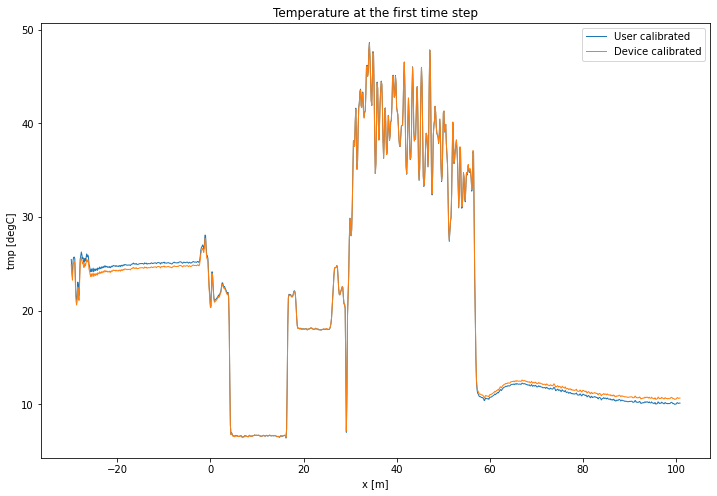

In [5]:
ds1 = ds100.isel(time=0)  # take only the first timestep

ds1.tmpf.plot(linewidth=1, figsize=(12, 8), label='User calibrated')  # plot the temperature calibrated by us
ds1.tmp.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.title('Temperature at the first time step')
plt.legend();